In [176]:
# Necessary packages
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import utils
import sys, os

# Load data

In [177]:
def load_data(data_type, dataset, perc): 
    if data_type == 'orig':
        # orig data
        sample_file_name = orig_data_dir + f'{dataset}_subsampled_train_perc_{perc}.npz'
        loaded = np.load(sample_file_name)
        orig_data = loaded['data']
        return orig_data
    else: 
        # gen data
        sample_file_name = gen_data_dir + f'{model}_gen_samples_{dataset}_perc_{perc}.npz'
        print(sample_file_name)
        if os.path.exists(sample_file_name):
            loaded = np.load(sample_file_name)
            gen_data = loaded['data']
        else: 
            gen_data = None
        return gen_data
    


# Scale Data

In [178]:

class MinMaxScaler():
    """Min Max normalizer.
    Args:
    - data: original data

    Returns:
    - norm_data: normalized data
    """
    def fit_transform(self, data): 
        self.fit(data)
        scaled_data = self.transform(data)
        return scaled_data


    def fit(self, data):    
        self.mini = np.min(data, 0)
        self.range = np.max(data, 0) - self.mini
        return self
        

    def transform(self, data):
        numerator = data - self.mini
        scaled_data = numerator / (self.range + 1e-7)
        return scaled_data

    
    def inverse_transform(self, data):
        data *= self.range
        data += self.mini
        return data

In [179]:
def scale_data(orig, gen, scale_gen_data=True): 
    scaler_orig = MinMaxScaler( )  
    scaled_orig_data = scaler_orig.fit_transform(orig)
    if scale_gen_data: 
        scaled_gen_data = scaler_orig.transform(gen)
    else: scaled_gen_data = gen
    return scaled_orig_data, scaled_gen_data

In [180]:
def avg_over_feat_dim(orig, gen): 
    final_orig = orig.mean(axis=2)
    final_gen = gen.mean(axis=2)
    return final_orig, final_gen

In [181]:
def shuffle_and_subsample(orig, gen, num=1000):     
    np.random.shuffle(orig)
    np.random.shuffle(gen)
    final_orig = orig[:num]
    final_gen = gen[:num]
    return final_orig, final_gen    

In [182]:
def print_all_data():
    print(orig_data.mean(axis=0).mean(axis=1))
    print(gen_data.mean(axis=0).mean(axis=1))
    
    print('scaled orig and gen data shape: ', scaled_orig_data.shape, scaled_gen_data.shape)
    print('scaled orig data mean: ', scaled_orig_data.mean())
    print('scaled gen data mean: ', scaled_gen_data.mean())
    print('final_orig shape: ', final_orig.shape)
    print('final_gen shape: ', final_gen.shape)

../../data/generated_data/vae_conv_I/vae_conv_I_gen_samples_air_perc_2.npz
../../data/generated_data/vae_conv_I/vae_conv_I_gen_samples_air_perc_5.npz
../../data/generated_data/vae_conv_I/vae_conv_I_gen_samples_air_perc_10.npz
../../data/generated_data/vae_conv_I/vae_conv_I_gen_samples_air_perc_20.npz
../../data/generated_data/vae_conv_I/vae_conv_I_gen_samples_air_perc_100.npz
../../data/generated_data/vae_conv_I/vae_conv_I_gen_samples_energy_perc_2.npz
../../data/generated_data/vae_conv_I/vae_conv_I_gen_samples_energy_perc_5.npz
../../data/generated_data/vae_conv_I/vae_conv_I_gen_samples_energy_perc_10.npz
../../data/generated_data/vae_conv_I/vae_conv_I_gen_samples_energy_perc_20.npz
../../data/generated_data/vae_conv_I/vae_conv_I_gen_samples_energy_perc_100.npz
../../data/generated_data/vae_conv_I/vae_conv_I_gen_samples_sine_perc_2.npz
../../data/generated_data/vae_conv_I/vae_conv_I_gen_samples_sine_perc_5.npz
../../data/generated_data/vae_conv_I/vae_conv_I_gen_samples_sine_perc_10.np

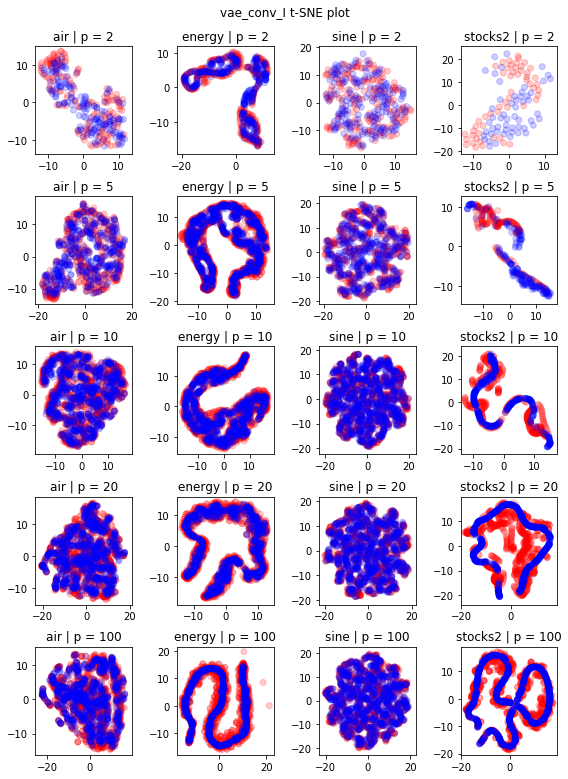

In [183]:
model = 'vae_conv_I'          # vae_conv_I, vae_IN, rcgan, T_forcing, timegan
orig_data_dir = "../../data/processed_orig_data/"
gen_data_dir = f"../../data/generated_data/{model}/"


scale_gen_data = True if model == 'vae_conv_I' else False


# datasets = [ 'stocks', 'stocks2']           # sine, stocks, stocks2, air, energy
datasets = ['air', 'energy', 'sine', 'stocks2', ]           # sine, stocks, stocks2, air, energy
percs = [ 2, 5, 10, 20, 100 ]


figsize = ( len(datasets ) * 2, 1 + len(percs) * 2)   # width by height
fig, axs = plt.subplots(len(percs), len(datasets), figsize=figsize)

for i, dataset in enumerate(datasets): 
    
    for j, perc in enumerate(percs):
        orig_data = load_data('orig', dataset, perc)
        gen_data = load_data('gen', dataset, perc)
#         print("orig, gen shapes: ", dataset, perc, orig_data.shape, gen_data.shape)

        if gen_data is None: continue
        
        N, T, D = orig_data.shape
        scaled_orig_data, scaled_gen_data = scale_data(orig_data, gen_data, scale_gen_data = scale_gen_data) 
        
        
        scaled_orig_2d, scaled_gen_2d = avg_over_feat_dim(scaled_orig_data, scaled_gen_data) 
        final_orig, final_gen = shuffle_and_subsample(scaled_orig_2d, scaled_gen_2d)        
        
        if final_orig.shape[0] != final_gen.shape[0]:
            final_orig = final_orig[:final_gen.shape[0]]
        
        N, T = final_orig.shape
        final_tsne_input = np.concatenate((final_orig, final_gen), axis = 0)        
#         print('final_tsne_input shape: ', final_tsne_input.shape)

        # TSNE analysis
        tsne = TSNE(n_components = 2, perplexity = 40, n_iter = 300)
        tsne_results = tsne.fit_transform(final_tsne_input)

        colors = ["red" for i in range(N)] + ["blue" for i in range(N)] 

        axs[j,i].scatter(tsne_results[:N,0], tsne_results[:N,1], 
                    c = colors[:N], alpha = 0.2)
        axs[j,i].scatter(tsne_results[N:,0], tsne_results[N:,1], 
                    c = colors[N:], alpha = 0.2)
        

flat_labels = [(xl, yl) for xl in percs for yl in datasets]

for i, ax in enumerate(axs.flat):
    perc, dataset = flat_labels[i]
    ax.set_title(f'{dataset} | p = {perc}')

# fig.legend()
fig.tight_layout()
plt.subplots_adjust(top=0.93)
plt.suptitle(f'{model} t-SNE plot')
plt.savefig(f"./tsne_charts/{model}_tsne_results.png", dpi=300)  
plt.show()

../../data/generated_data/vae_IN/vae_IN_gen_samples_stocks_perc_2.npz


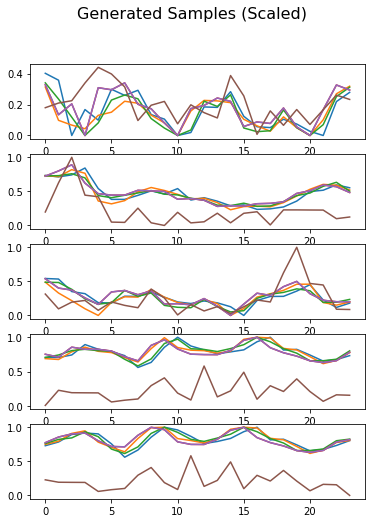

In [184]:
dataset, perc = 'stocks', 2

model = 'vae_IN'          # vae_conv_I, vae_IN, rcgan, T_forcing, timegan

orig_data_dir = "../../data/processed_orig_data/"
gen_data_dir = f"../../data/generated_data/{model}/"


scale_gen_data = True if model == 'vae_conv_I' else False

orig_data = load_data('orig', dataset, perc)    
gen_data = load_data('gen', dataset, perc)
N, T, D = gen_data.shape
# print(N, T, D)

scaled_orig_data, scaled_gen_data = scale_data(orig_data, gen_data, scale_gen_data) 

utils.plot_samples(scaled_orig_data, n=5)

# Grammian Matrix

In [185]:
N, T, D = scaled_orig_data.shape
num_samples = min(200, N)

gram_orig = scaled_orig_data[np.random.randint(N, size=num_samples), :]
gram_gen = scaled_gen_data[np.random.randint(N, size=num_samples), :]


gram_orig = gram_orig.reshape((num_samples, -1))
gram_gen = gram_gen.reshape((num_samples, -1))
gram_orig.shape, gram_gen.shape

gram_orig = gram_orig.dot(gram_orig.T) / T
gram_gen = gram_gen.dot(gram_gen.T) / T
# gram_orig.shape, gram_gen.shape

gram_metric_orig = gram_orig.sum() / gram_orig.size
gram_metric_gen = gram_gen.sum() / gram_gen.size
gram_metric_orig, gram_metric_gen

(1.30883065311423, 2866197053433.1763)